### $\textbf{Python Notebook for Macrostate-Discovery
on High-Dimensional Distributions of Biological Data}$
$$\textbf{Seed Authors: Enoch Yeung$^1$, Robert Egbert$^2$,}$$
$$\textbf {1 - Data Science and Analytics Group}$$
$$\textbf{2 - Microbiome Sciences Group}$$ 
$$\textbf{ Pacific Northwest National Laboratory}$$



In [1]:
%%bash
source activate python2
pip install -U pygraphviz --install-option="--include-path=/usr/local/Cellar/graphviz/2.40.1/include/graphviz" \
--install-option="--library-path=/usr/local/Cellar/graphviz/2.40.1/lib" --user
pip install -U networkx

Requirement already up-to-date: pygraphviz in /Users/yeun026/Library/Python/2.7/lib/python/site-packages
Requirement already up-to-date: networkx in /Users/yeun026/Library/Python/2.7/lib/python/site-packages
Requirement already up-to-date: decorator>=4.1.0 in /Users/yeun026/Library/Python/2.7/lib/python/site-packages (from networkx)


bash: line 1: activate: No such file or directory
/Library/Python/2.7/site-packages/pip/commands/install.py:194: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)


### Import Packages



In [2]:
import numpy as np;
import networkx as nx;
import pandas as pd; 
from networkx.algorithms import bipartite; 
import matplotlib.pyplot as plt;

import seaborn as sns;
import matplotlib as mpl;

sns.set(style="ticks", color_codes=True)
%matplotlib inline

#plt.plot()


In [3]:
import pygraphviz as PG
from scipy import special


### Define Support Functions: gen_pdf(), gen_micro_graph(), distance metrics 


In [4]:
def jensen_shannon_divergence(a, b):
     """Compute Jensen-Shannon Divergence
 
     Parameters
     ----------
     a : array-like
         possibly unnormalized distribution.
     b : array-like
         possibly unnormalized distribution. Must be of same shape as ``a``.
 
     Returns
     -------
     j : float
 
     See Also
     --------
     jsd_matrix : function
         Computes all pair-wise distances for a set of measurements
     entropy : function
         Computes entropy and K-L divergence
     """
     a = np.asanyarray(a, dtype=float)
     b = np.asanyarray(b, dtype=float)
     a = a/a.sum(axis=0)
     b = b/b.sum(axis=0)
     m = (a + b)
     m /= 2.
     m = np.where(m, m, 1.)
     return 0.5*np.sum(special.xlogy(a, a/m) + special.xlogy(b, b/m), axis=0)

In [5]:
"""
Specifically, the Kullback–Leibler divergence from Q to P, denoted DKL(P‖Q), is
a measure of the information gained when one revises one's beliefs from the
prior probability distribution Q to the posterior probability distribution P. In
other words, it is the amount of information lost when Q is used to approximate
P.
"""
import numpy as np
from scipy.stats import entropy

def kl(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=n
    Discrete probability distributions.
    """
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    #print p
    #print q
    diverg_sum = 0.0;
    for ind in range(0,len(p)):
        if (p[ind]!=0) & (q[ind]!=0):
            diverg_sum = diverg_sum + p[ind]*np.log(p[ind]/q[ind]);
            
    return diverg_sum;#np.sum(np.where(p != 0 & q!=0, p * np.log(p / q), 0))



#p = [0.1, 0.9]
#q = [0.1, 0.9]
#assert entropy(p, q) == kl(p, q)

In [162]:
### This function takes a flow dataframe and turns it into a high-dimensional empirical PDF 
def gen_pdf(dataframe,bin_count=5):    
    temp_array = np.histogramdd(dataframe,bins=bin_count,normed=True);
    total_count = np.sum(temp_array[0],axis=None);
    output = np.asarray(temp_array[0])/total_count;
    #np.asarray(temp_array[0]/total_count);
    # [DEBUG]:  print temp_array[0]/total_count;
    # [DEBUG]: print np.sum(temp_array[0]/total_count);
    return output;

### This function takes a list of PDFs and generates a graph object 
def gen_micro_graph(pdf_list,node_labels,url_list,clustered=False,labels=[]):
    node_size = 1; 
    
    PG_graph = PG.AGraph(); 
    nlist = node_labels;
    colors = ['#2c9fd1','#ed5740','#f8d14c','#cd6136','#685858','#185858','#685228','#333858' ]; 
    for i in range(0,len(nlist)):
        temp_node = nlist[i]; 
        temp_url = url_list[i];
        if not clustered:
            PG_graph.add_node(temp_node,fixedsize=True, width=0.2,height=0.2,fontsize=6,fontcolor='#000000',fillcolor='#685858',color='#0000ff96',URL=temp_url,style='filled');
        if clustered:
            PG_graph.add_node(temp_node,fixedsize = True,width=0.2,height=0.2, fontsize=6,fontcolor='#000000',color='#FFFFFF',fillcolor=colors[labels[i]],URL=temp_url,style='filled');

    PG_graph.node_attr.update(color='red',style='empty',shape='circle');
    adj_matrix = gen_adjacency_matrix(pdf_list);
    adj_matrix = adj_matrix*4.0/np.max(adj_matrix,axis=None) + 0.1;

    #edge_weights = []; 
    #for index1 in range(0,len(pdf_list)):
    #    for index2 in range(index1+1,len(pdf_list)):
    #        #print "Calculated Distance: " + repr(pdf_wass_dist(pdf_list[index1],pdf_list[index2]));
    #        #temp_edge_weight = pdf_wass_dist(pdf_list[index1],pdf_list[index2]);
    #        print "Calculated Distance: " + repr(ms_distance(pdf_list[index1],pdf_list[index2]));
    #        temp_edge_weight = ms_distance(pdf_list[index1],pdf_list[index2]);
    #        edge_weights.append(temp_edge_weight); 

    
    #edge_weights = list(10.0*(np.asarray(edge_weights)/np.max(edge_weights)) +1.0)
    #temp_index = 0;
    for index1 in range(0,len(pdf_list)):
        for index2 in range(index1+1,len(pdf_list)):
            if adj_matrix[index1][index2]>-100.0:
                PG_graph.add_edge(node_labels[index1],node_labels[index2],color='#00000016',len=adj_matrix[index1][index2],edge_alpha=0.5)   
            else:
                PG_graph.add_edge(node_labels[index1],node_labels[index2],color='black',len=adj_matrix[index1][index2],edge_alpha=0.5,style='invis')   
            #temp_index = temp_index+1;       
            
            
    PG_graph.draw('plots/pdf_graph.svg', format='svg', prog='neato')
    
    return np.ndarray.flatten(adj_matrix); 


def pdf_log_dist(pdf1,pdf2):    
    shape_1 = pdf1.shape;
    shape_2 = pdf2.shape;     
    delta_pdf = 0.5*np.abs(np.log10(pdf1)-np.log10(pdf2)) +  0.5*np.abs(np.log10(pdf2) - np.log10(pdf1)); 

        
def wass_distance(pdf1,pdf2,max_p=10): #Wasserstein Distance with max_p up to 10 
    Delta_pdf = 0.5*np.abs(pdf1-pdf2) + 0.5*np.abs(pdf2-pdf1); # must be a symmetric measure of distance 
    
    Delta_pdf_flatten =  np.ndarray.flatten(Delta_pdf); 
    total_min_out = 1.0*np.Inf; 
    for p_index in range(0,max_p):
        sum_out = 0.0; 
        for elem in Delta_pdf_flatten:
            sum_out = sum_out + np.power(np.abs(elem),1.0*p_index);
        if sum_out < total_min_out:
            total_min_out = sum_out; 
    
    mean_min_out = total_min_out/(1.0*len(Delta_pdf_flatten));
    return mean_min_out; 

def pdf_abs_dist(pdf1,pdf2):
    shape_1 = pdf1.shape;
    shape_2 = pdf2.shape;    
    delta_pdf = pdf1-pdf2;
    delta_pdf = np.ndarray.flatten(delta_pdf);
    out_dist = np.sum(np.abs(delta_pdf))/len(delta_pdf); 
    #print delta_pdf
    return out_dist; 


def ms_distance(pdf1,pdf2):  # current metric space definition 
    #print jensen_shannon_divergence(pdf1,pdf2);
    #return np.sum(np.abs(jensen_shannon_divergence(pdf1,pdf2)));
    #return kl(pdf1,pdf2)
    #return wass_distance(pdf1,pdf2,max_p=10);
    return 0.5*pdf_abs_dist(pdf1,pdf2)+0.5*pdf_abs_dist(pdf2,pdf1);
 

def gen_adjacency_matrix(pdf_list):
    n_microstates = len(pdf_list);  
    output_matrix = np.zeros((n_microstates,n_microstates));
    for temp_index1 in range(0,n_microstates):
        for temp_index2 in range(temp_index1+1,n_microstates):
            Temp_pdf1 = pdf_list[temp_index1];
            Temp_pdf2 = pdf_list[temp_index2];
            
            output_matrix[temp_index1][temp_index2] = ms_distance(Temp_pdf1,Temp_pdf2);
            output_matrix[temp_index2][temp_index1] = ms_distance(Temp_pdf1,Temp_pdf2); 
            #print "Calculating symmetric abs. difference: " + repr(ms_distance(Temp_pdf1,Temp_pdf2));
    return output_matrix; 

def gen_heat_map(adjacency_matrix,cond_labels):
    ### Code courtesy of Bree Cummings 
    plt.figure()
    mpl.rc('xtick', labelsize=12) 
    mpl.rc('ytick', labelsize=12)         
    plt.imshow(adjacency_matrix,interpolation='nearest')
    plt.colorbar()
    plt.xticks(range(len(adjacency_matrix[0])),cond_labels,rotation=90)
    plt.yticks(range(len(adjacency_matrix[0])),cond_labels)
    ax=plt.gca();
    ax.xaxis.tick_top()
    plt.clim(0,np.max(adjacency_matrix));
    plt.show();
    return ax;

def flowViz(df,lab,date):

    n = 1
    channel = 'FL{}-H'.format(n)
    sns.set_style('ticks')
    fig, ax = plt.subplots(4,2,figsize=(8,11),sharex=True)
    sns.set_palette('cubehelix',3)
    cond = ['XOR_00','XOR_01','XOR_10','XOR_11']
    for c, axR in zip(cond,range(4)):
        ax[axR,0].annotate(c,(0.05,0.85),xycoords='axes fraction')
        dfT = df[df['Strain'] == c]
        for samp in sorted(set(dfT.bioReplicate)):
            data = dfT[dfT['bioReplicate'] == samp]['{}-H'.format(channel)]
            sns.distplot(np.log10(data[data > 0]),hist=False,ax = ax[axR,0])
            ax[axR,0].legend(['R1','R2','R3'],loc='upper left')
            ax[axR,0].set_xlim([1,5])
            data = dfT[dfT['bioReplicate'] == samp]['{}-A'.format(channel)]
            sns.distplot(np.log10(data[data > 0]),hist=False,ax = ax[axR,1])
            ax[axR,1].legend(['R1','R2','R3'])
            ax[axR,1].set_xlim([1,5])
    sns.despine()
    fig.savefig(outputDir+'plots/{}_flow_{}_{}.pdf'.format(lab,channel,date))

def overlay_plot(df_list,cond_labels,channel='FL1-H',outputDir='plots/time_plots/'):
    colors = np.random.rand(len(df_list),3); 
    
    fig,this_axis = plt.subplots(1,1,sharex=True); 
    for index in range(0,len(df_list)):

        df = df_list[index];
        #print df[channel].as_matrix()[0:10]
        #print "Normalizing factor"  + repr(np.sum(df[channel].as_matrix()));
        sns_plot = sns.kdeplot(df[channel], ax=this_axis,color=colors[index],label=cond_labels[index],gridsize=1000)
        sns_plot.set(xscale='log',yscale='linear');
        sns_plot.set_xlim((10.0,1e5))
    plt.show()
    fig.savefig(outputDir+ ','.join(cond_labels) +  '.pdf');
    
    return this_axis;

def overlay_hist(pdf_pair_list,cond_labels,channel='FL1-H',outputDir='plots/time_plots/'):
    colors = np.random.rand(len(pdf_pair_list),3); 
    
    fig,this_axis = plt.subplots(1,1,sharex=True);
    for index in range(0,len(df_list)):
        df = df_list[index];
        sns_plot = sns.kdeplot(df[channel], ax=this_axis,color=colors[index],label=cond_labels[index],gridsize=1000)
        sns_plot.set(xscale='log',yscale='linear');
        sns_plot.set_xlim((10.0,1e5))
    plt.show()
    fig.savefig(outputDir+ ','.join(cond_labels) +  '.pdf');
    
    return this_axis;

def prefilter(Dataframe,Channels):
    Dataframe = Dataframe[Channels];
    Dataframe = Dataframe[Dataframe[Channels]>1.0];
    Dataframe = Dataframe.dropna(axis=0,how='any');
    return Dataframe; 

### Supporting plot functions

In [172]:
def plot_channels(Curr_DataFrame,condition):
    file_path = 'channel_plots/'+condition + '.pdf'
    
    FL1_LowerLim = 1e1;
    FSC_LowerLim = 1e4;
    SSC_LowerLim = 1e3;
    
    FL1_UpperLim = 1e6;
    FSC_UpperLim = 1e7;
    SSC_UpperLim = 1e5; 
    
    LowerLim = [FL1_LowerLim,FSC_LowerLim,SSC_LowerLim];
    UpperLim = [FL1_UpperLim,FSC_UpperLim,SSC_UpperLim];
    
    #LowerLim = [FL1_LowerLim,FL1_LowerLim];
    #UpperLim = [FL1_UpperLim,FL1_UpperLim];


    if len(Curr_DataFrame)>0:
        #sns.set(font_scale=0.25);
        #sns_plot = sns.pairplot(Curr_DataFrame.sample(len(Curr_DataFrame)/2), diag_kind='kde', palette="husl"); 
        sns_plot = sns.pairplot(Curr_DataFrame.sample(len(Curr_DataFrame)/2), diag_kind='kde', palette="husl"); 
        plt.suptitle(condition);
        sns_plot.set(xscale='log',yscale='log');

        axes_handle = sns_plot.axes;
        n_rows = len(axes_handle)
        n_cols = len(axes_handle[0])
        
        
        for i in range(0,n_rows):
            for j in range(0,n_cols):
                #axes_handle[i,j].set_ylim(LowerLim[j],UpperLim[i]);
                #axes_handle[i,j].set_xlim(LowerLim[j],UpperLim[i]);
                if i==j:
                    sns_plot.set(xscale='linear',yscale='linear');
    else:
        sns_plot = sns.pairplot(Curr_DataFrame, diag_kind='kde',palette="husl"); 
    
    
    sns_plot.savefig('plots/' +file_path);

        
    return file_path; 



### This module clusters and defines a "condensation" graph (components are not necessarily epsilon-strongly connected) 
### This code plots the graph object. 

### Import Files as Pandas Dataframes 


In [173]:
### MAIN ### 

### File Import

outputDir = 'processedFlowDataFrames/'

Gink_F_Flow_DF = pd.read_csv(outputDir+'Gink_F.csv');
Gink_P_Flow_DF = pd.read_csv(outputDir+'Gink_P.csv');
Tran_F_Flow_DF = pd.read_csv(outputDir+'Tran_F.csv');
Tran_P_Flow_DF = pd.read_csv(outputDir+'Tran_P.csv');


#FlowDate = '2017_preMeasurement'
#OutputDir = '';
#OriginatorLab = 'Ginkgo';

#DfP = pd.read_csv(OutputDir+OriginatorLab+'_'+FlowDate+'_sampleTable.csv',index_col=0)
#DfPre = pd.read_csv(OutputDir+OriginatorLab+'_'+FlowDate+'_flowDataFrame.csv',index_col=0)


#DfPre = Gink_P_Flow_DF; 
#DfFinal = Gink_F_Flow_DF; 
DfPre = Tran_F_Flow_DF ;
DfFinal = Tran_P_Flow_DF;

#FlowDate = '2017_finalMeasurement'

#DfF = pd.read_csv(OutputDir+OriginatorLab+'_'+FlowDate+'_sampleTable.csv',index_col=0)
#DfFinal = pd.read_csv(OutputDir+OriginatorLab+'_'+FlowDate+'_flowDataFrame.csv',index_col=0)


### Standardize datatypes within fields. 

In [174]:
#print DfF.head()
DfFinal.StrainID = DfFinal.StrainID.apply(str)
DfFinal.BioReplicate = DfFinal.BioReplicate.apply(str)
DfFinal.TechReplicate = DfFinal.TechReplicate.apply(str)
DfFinal.ExtractionOD = DfFinal.ExtractionOD.apply(str); 

StrainList = list(set(list(DfFinal.StrainID)));
StrainList = StrainList[0:]
if 'Beads' in StrainList:
    StrainList.remove('Beads')

print StrainList

BioRep = list(set(list(DfFinal.BioReplicate)));

if 'Null' in BioRep:
    BioRep.remove('Null')
    print BioRep 

TechRep = list(set(list(DfFinal.TechReplicate)));
if 'Null' in TechRep:
    TechRep.remove('Null')
print TechRep

['XOR_11', 'XOR_10', 'XOR_00', 'XOR_01']
['1', '3', '2', '5', '4', '6']
['1']


### Calculate and Plot Microstates

In [175]:
### Microstate Analysis  ### 

### Helper commands ### 
#print dfPre.head()
#print DfFinal.head()


### Analysis hyperparameters, metavariables 
n_bins = 4; 


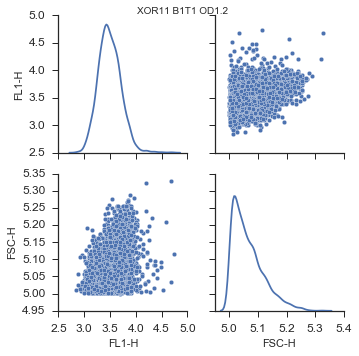

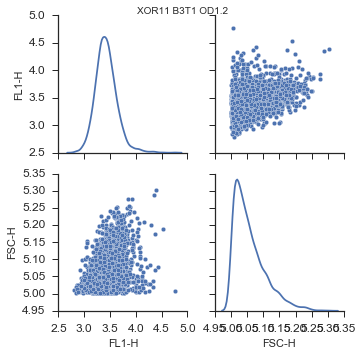

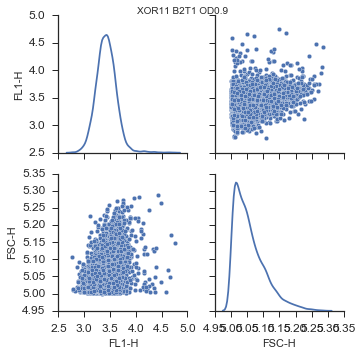

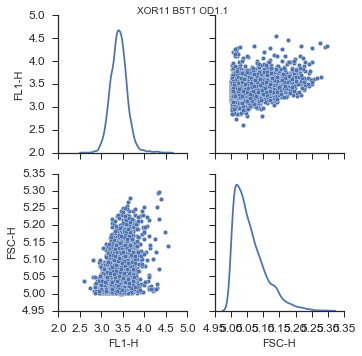

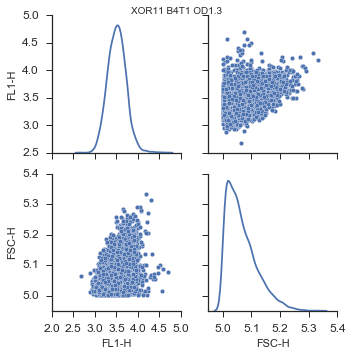

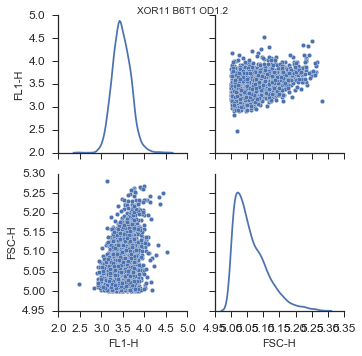

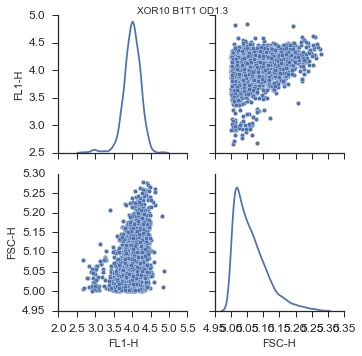

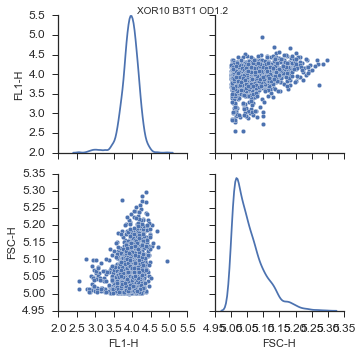

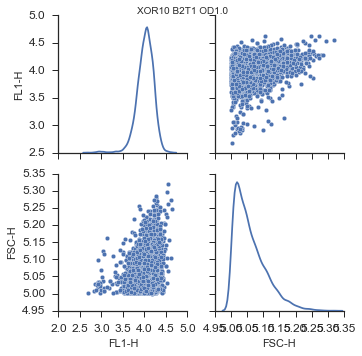

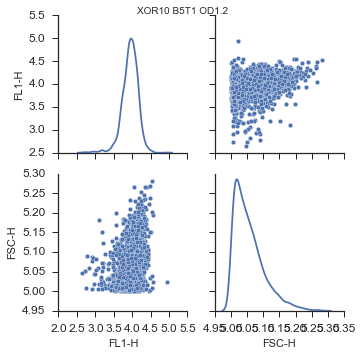

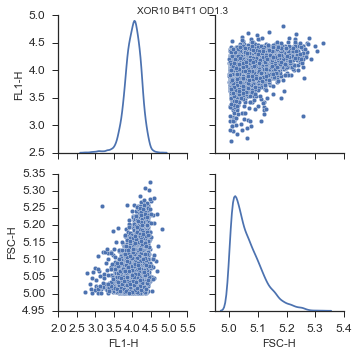

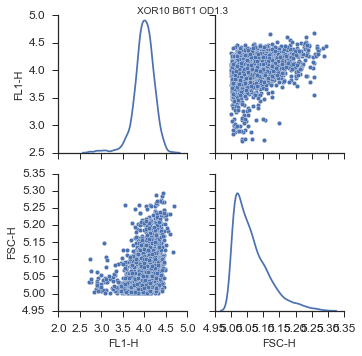

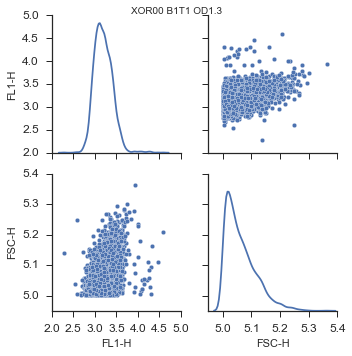

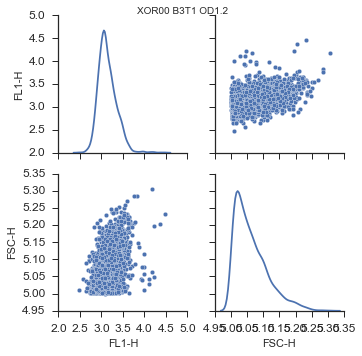

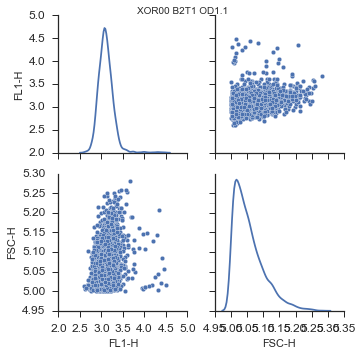

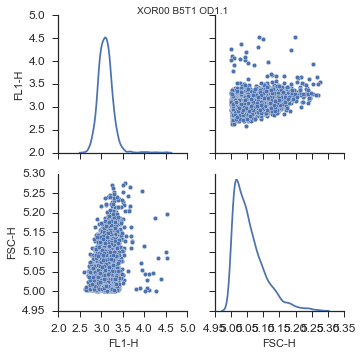

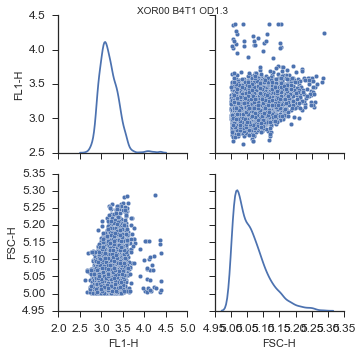

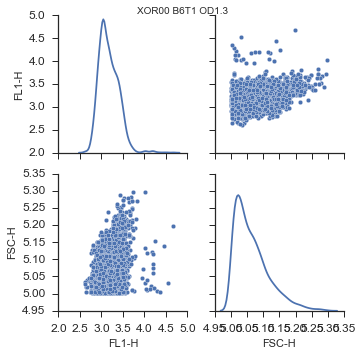

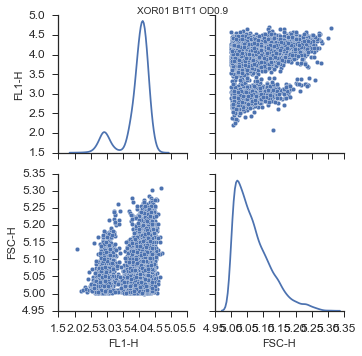

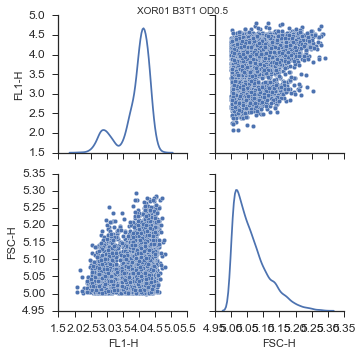

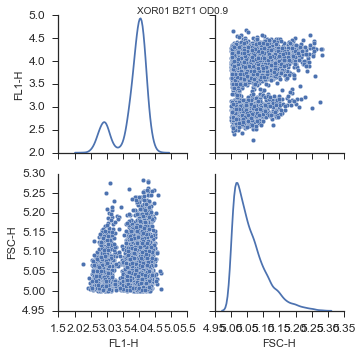

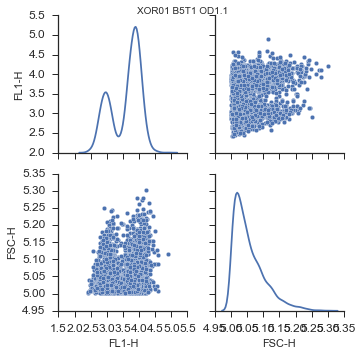

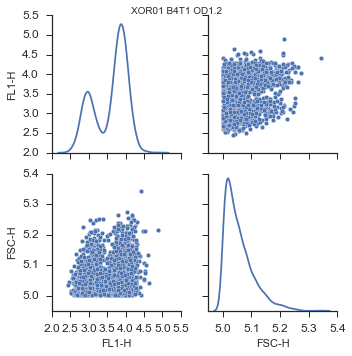

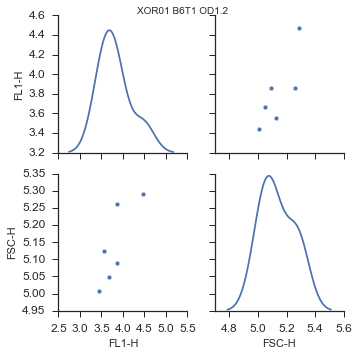

In [176]:
###  Channel Selection 
#Channels = ['FL1-A','FL1-H','FSC-A','FSC-H','SSC-A','SSC-H','Width']
#Channels = ['FL1-H','FSC-H','SSC-H'];
#Channels = ['FL1-A','FSC-A','SSC-A']; 
#Channels = ['FL1-A','FL1-H']
XOR01Data = []
XOR01Label = [];
XOR01URL = []; 
XOR01OD = [];


plt.close('all')
Channels = ['FL1-H','FSC-H'];


All_PDF = [];
All_Hist = [];
Condition_Labels = [];
HeatMap_Condition_Labels = []; 
All_URLs = []; 
for Strain_Str in StrainList:
    TargetDF_Str = DfFinal[DfFinal['StrainID']==Strain_Str]  
    #print "TargetDF_Str.head(): " + repr(TargetDF_Str.head());
    for BioRepNum in BioRep:
        TargetDF_StrBio = TargetDF_Str[TargetDF_Str['BioReplicate']==BioRepNum]        
        frame_shape = TargetDF_StrBio.as_matrix().shape; 
        
        if not ((len(frame_shape)==2 and frame_shape[0]>0)):
           
            TempOD = list(set(TargetDF_StrBio['ExtractionOD']));
            TempOD = ['{0:.1f}'.format(a) for a in TempOD];
            try:
                Str_Condition = Strain_Str + '\n B' + str(int(BioRepNum)) +  '\n OD: '+ ','.join([ str(od) for od in TempOD]); # + 'T' + str(int(TechRepNum)); # + sample_OD  
            except:
                Str_Condition = Strain_Str + '\n B' + repr(BioRepNum) +  '\n OD: '+ ','.join([ str(od) for od in TempOD]); # + 'T' + str(int(TechRepNum)); # + sample_OD  
            print "Warning, empty data frame: " + Str_Condition  + " Frame shape: " + repr(frame_shape);  
            
        if (len(frame_shape)==2) and (frame_shape[0]>0):
            
            for TechRepNum in TechRep: 

                TargetDF_StrTech = TargetDF_StrBio[TargetDF_StrBio['TechReplicate']==TechRepNum][Channels]; 
                TargetDF_StrTech = TargetDF_StrTech[TargetDF_StrTech[Channels]>100.0];
                TargetDF_StrTech = TargetDF_StrTech.dropna(axis=0,how='any');

                Target_PDF = gen_pdf(np.log10(TargetDF_StrTech.as_matrix()),n_bins);
                Target_Matrix = np.log10(TargetDF_StrTech.as_matrix()); 
                TempOD = list(set(TargetDF_StrBio[TargetDF_StrBio['TechReplicate']==TechRepNum]['ExtractionOD']));
                if len(TempOD)>1:
                    print TempOD
                    print "Warning, multiple ODs detected.";
                    TempOD = [TempOD[0]];
                if len(TempOD)==1:
                    try:
                        TempOD = float(TempOD[0]);
                        TempOD = '{0:.1f}'.format(TempOD);
                    except:
                        TempOD = repr(TempOD);
                if len(TempOD)==0:
                    TempOD = 'NC';

                
                #TempOD = ['{0:.1f}'.format(a) for a in TempOD if type(a)==float];
                #TempOD = ','.join(TempOD); 
                tech_frame_shape = TargetDF_StrTech.as_matrix().shape; 
                
                
                try:
                    Strain_Str = ''.join(Strain_Str.split('_'))
                    Condition = Strain_Str + ' B' + str(int(BioRepNum)) + 'T' + str(int(TechRepNum))+ ' OD: '+ TempOD;   
                    HeatMap_Condition =  Strain_Str + 'B' + str(int(BioRepNum)) + 'T' + str(int(TechRepNum))+ ' OD: '+ TempOD;   
                    File_Suffix = Strain_Str+ ' B'+str(int(BioRepNum))  +'T' + str(int(TechRepNum))+ ' OD' + TempOD; 
                except:
                    Strain_Str = ''.join(Strain_Str.split('_'))
                    print "BioRepNum:" + repr(BioRepNum);
                    print "TechRepNum:" + repr(TechRepNum);
                    Condition = Strain_Str + ' B' + repr(BioRepNum) + 'T' + repr(TechRepNum)+ '\n OD: '+ repr(TempOD);   
                    HeatMap_Condition =  Strain_Str + 'B' + repr(BioRepNum) + 'T' + repr(TechRepNum)+ ' OD: '+ repr(TempOD);   
                    File_Suffix = Strain_Str+ ' B'+repr(BioRepNum)  +'T' + repr(TechRepNum)+ ' OD' + repr(TempOD); 
                

                if len(tech_frame_shape)==2 and tech_frame_shape[0]>0:
                    All_PDF.append(Target_PDF);                    
                    All_Hist.append(Target_Matrix);
                    url_handle = plot_channels(np.log10(TargetDF_StrTech),File_Suffix)
                    Condition_Labels.append(Condition); 
                    HeatMap_Condition_Labels.append(HeatMap_Condition); 
                    All_URLs.append(url_handle);
                    if 'XOR01' in Strain_Str: 
                        XOR01Data.append(Target_Matrix);
                        XOR01Label.append(Condition); 
                        XOR01URL.append(url_handle); 
                        XOR01OD.append(TempOD);



Done Generating Graph: Plotting Histogram . . .


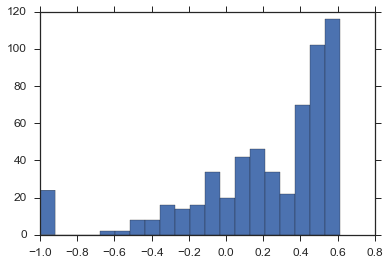

In [177]:
all_edge_weights = gen_micro_graph(All_PDF,Condition_Labels,All_URLs);

print "Done Generating Graph: Plotting Histogram . . .";
#print all_edge_weights
plt.hist(np.log10(all_edge_weights),bins=20);
plt.show()


### Calculate Adjacency Matrix

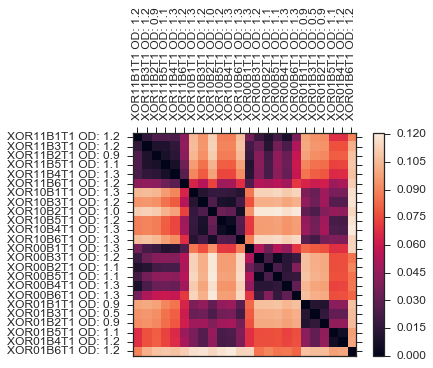

In [178]:
PDF_Adj_matrix = gen_adjacency_matrix(All_PDF);
gen_heat_map(PDF_Adj_matrix,HeatMap_Condition_Labels);

### Calculate and Plot Macrostates

In [179]:
 from sklearn.cluster import DBSCAN;
from sklearn import metrics;
from sklearn.datasets.samples_generator import make_blobs; 
from sklearn.preprocessing import StandardScaler; 

print "Clustering on " + repr(len(All_PDF)) + " probability density datapoints."



### Find maximal cluster count  
scan_eps = np.arange(0.001,2.5,0.001)
best_eps = 10.0; 
most_groups = 8; 
curr_groups = 3; 
for temp_eps in scan_eps: 
    db = DBSCAN(eps=temp_eps,min_samples=2).fit(PDF_Adj_matrix);
    #print db.labels_
    if curr_groups<len(set(db.labels_))<=most_groups:
        #print best_eps
        #curr_groups = len(set(db.labels_)); 
        best_eps = temp_eps; 
        #most_groups = len(list(set(db.labels_)));
        
db = DBSCAN(eps=best_eps,min_samples=2).fit(PDF_Adj_matrix);
db.labels_ = db.labels_+1;
print db.labels_
#print best_eps
#print Condition_Labels
#print All_URLs

all_edge_weights = gen_micro_graph(All_PDF,Condition_Labels,All_URLs,clustered=True,labels=db.labels_);

Clustering on 24 probability density datapoints.
[1 1 1 1 1 0 2 2 2 2 2 2 1 1 1 1 1 1 2 2 2 3 3 0]


(24, 24)


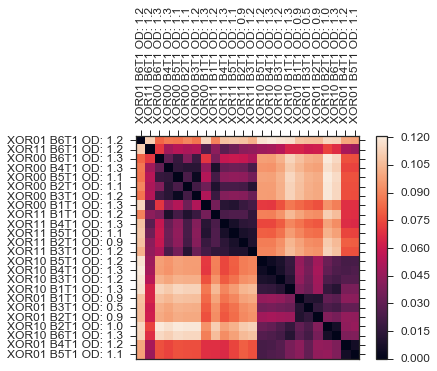

In [180]:

unordered_labels = list(db.labels_);
Sorted_labels = sorted([int(x) for x in unordered_labels]);
Sorted_indices = np.argsort([int(x) for x in unordered_labels]);

Transform_matrix = np.zeros(PDF_Adj_matrix.shape);
for ind in range(0,len(Transform_matrix[0])):
    Transform_matrix[ind][Sorted_indices[ind]] = 1.0;

TAT = np.dot(np.dot(Transform_matrix,PDF_Adj_matrix),np.linalg.inv(Transform_matrix))
print TAT.shape
Sorted_Conditions = [Condition_Labels[x] for x in Sorted_indices]; 
#PDF_Adj_matrix = gen_adjacency_matrix(All_PDF);
gen_heat_map(TAT,Sorted_Conditions);

### Macro-Koopman Classifier Training

### Import learning packages###

In [181]:
import tensorflow as tf 
from macro_Koopman_classifier import initialize_Wblist, train_net, weight_variable, bias_variable, initialize_tailconstrained_tensorflow_variables
from sklearn.metrics import f1_score,precision_score, recall_score,classification_report;
from sklearn.model_selection import train_test_split;

import macro_Koopman_classifier as mK
reload(mK)

<module 'macro_Koopman_classifier' from 'macro_Koopman_classifier.pyc'>

In [182]:

all_gross_labels = db.labels_;
print len(set(all_gross_labels))

num_classes = len(set(all_gross_labels));
all_sub_labels = []; 
dist_list = [];
n_total_artificial_samples = 30; 
sub_sampling = 25000; 
all_samples_generated = False; 
has_all_classes = [False]*len(set(all_gross_labels)); 
while not all_samples_generated:
    hist_index = np.random.randint(0,len(all_gross_labels),1)[0]
    This_Frame = All_Hist[hist_index]; 
    This_Class = all_gross_labels[hist_index]-1
    has_this_many_samples =  np.sum(all_sub_labels,axis=0)
    print has_this_many_samples
    if type(has_this_many_samples) == np.ndarray:
        has_this_many_samples = has_this_many_samples[This_Class]
        
    
    if has_this_many_samples > n_total_artificial_samples:
        has_all_classes[This_Class] = True;
    else:
        for k in range(0,3):
            sampling_indices = np.random.randint(0,This_Frame.shape[0],size=(sub_sampling));
            dist_list.append(gen_pdf(This_Frame[sampling_indices,:],n_bins));
            temp_label = [0.0]*num_classes; 
            temp_label[This_Class] = 1.0; 
            all_sub_labels.append(temp_label);
    if np.all(has_all_classes):
        all_samples_generated=True;
    

label_list = all_sub_labels; 

dist_list_train, dist_list_test, label_list_train, label_list_test = train_test_split(dist_list, label_list, test_size=0.33, random_state=42)

4
0.0
[ 3.  0.  0.  0.]
[ 6.  0.  0.  0.]
[ 6.  0.  0.  3.]
[ 9.  0.  0.  3.]
[ 12.   0.   0.   3.]
[ 12.   3.   0.   3.]
[ 15.   3.   0.   3.]
[ 18.   3.   0.   3.]
[ 18.   6.   0.   3.]
[ 21.   6.   0.   3.]
[ 24.   6.   0.   3.]
[ 27.   6.   0.   3.]
[ 27.   9.   0.   3.]
[ 30.   9.   0.   3.]
[ 33.   9.   0.   3.]
[ 33.   9.   0.   6.]
[ 33.  12.   0.   6.]
[ 33.  12.   0.   6.]
[ 33.  12.   0.   6.]
[ 33.  12.   0.   6.]
[ 33.  12.   0.   6.]
[ 33.  12.   0.   6.]
[ 33.  15.   0.   6.]
[ 33.  15.   0.   6.]
[ 33.  18.   0.   6.]
[ 33.  21.   0.   6.]
[ 33.  24.   0.   6.]
[ 33.  24.   0.   6.]
[ 33.  24.   0.   6.]
[ 33.  27.   0.   6.]
[ 33.  27.   0.   6.]
[ 33.  27.   0.   9.]
[ 33.  27.   0.   9.]
[ 33.  27.   3.   9.]
[ 33.  30.   3.   9.]
[ 33.  30.   3.   9.]
[ 33.  30.   3.   9.]
[ 33.  30.   3.   9.]
[ 33.  30.   6.   9.]
[ 33.  33.   6.   9.]
[ 33.  33.   6.   9.]
[ 33.  33.   6.   9.]
[ 33.  33.   6.   9.]
[ 33.  33.   6.   9.]
[ 33.  33.   9.   9.]
[ 33.  33.   9.   9.

### Tensorflow Hyperparameters ###

In [183]:

n_channels = len(Channels);
print n_channels

step_size_val = 2.5e-2;
max_width = 41;# 50
n_depth = 4;
hidden_vars_list = np.asarray([max_width]*n_depth);
hidden_vars_list[-1] = len(label_list[0]);
valid_error_threshold = 1e-3;
test_error_threshold = 1e-3;
max_iters =5000;
#step_size_val = 5e-2;
with_control = 0;
batchsize = 30;
with_input_cond = 0; 

2


### Tensorflow Main (Classifier Training) ###

In [184]:


step_size = tf.placeholder(tf.float32,shape=[]);
sess= tf.InteractiveSession();
W_list,b_list = initialize_Wblist(n_bins,hidden_vars_list);
z_list_alias,y,u = mK.initialize_tailconstrained_tensorflow_variables(n_channels,n_bins,hidden_vars_list,W_list,b_list,activation_flag=2);

#y = tf.transpose(y);
y_ = tf.placeholder(tf.float32, [None,num_classes]);

print repr(y.get_shape())
print repr(y_.get_shape());

y = tf.nn.softmax(y);
#cross_entropy = tf.norm(y_-y)/tf.norm(y_);#
#cross_entropy = tf.nn.l2_loss(y-y_);
cross_entropy = tf.norm(tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=y));#tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y)));# reduction_indices=[1]))
optimizer = tf.train.AdagradOptimizer(step_size_val).minimize(cross_entropy);
#yp_feed  = u;
#yf_feed = y_;
sess.run(tf.initialize_all_variables());
all_histories,good_start = train_net(dist_list_train,label_list_train,cross_entropy,optimizer,batchsize,with_input_cond,u,y,y_,step_size,valid_error_threshold,test_error_threshold,max_iters/10,step_size_val);
all_histories,good_start = train_net(dist_list_train,label_list_train,cross_entropy,optimizer,batchsize,with_input_cond,u,y,y_,step_size,valid_error_threshold,test_error_threshold,max_iters/10,step_size_val/2);
all_histories,good_start = train_net(dist_list_train,label_list_train,cross_entropy,optimizer,batchsize,with_input_cond,u,y,y_,step_size,valid_error_threshold,test_error_threshold,max_iters,step_size_val/10);


shape of u:[None, 4, 4]
[4, 1]
[DEBUG] prev_layer_output.get_shape() TensorShape([Dimension(None), Dimension(41)])
[DEBUG] prev_layer_output.get_shape() TensorShape([Dimension(None), Dimension(41)])
[DEBUG] prev_layer_output.get_shape() TensorShape([Dimension(None), Dimension(4)])
Instructions for updating:
Use `tf.global_variables_initializer` instead.
TensorShape([Dimension(None), Dimension(4)])
TensorShape([Dimension(None), Dimension(4)])
Instructions for updating:
Use `tf.global_variables_initializer` instead.
step 1 , validation error 7.67763
step 1 , test error 7.56697
step 100 , validation error 5.71887
step 100 , test error 5.56248
step 200 , validation error 4.19753
step 200 , test error 4.18143
step 300 , validation error 4.11095
step 300 , test error 4.10553
step 400 , validation error 4.09405
step 400 , test error 4.08663
step 500 , validation error 4.08798
step 500 , test error 4.08181
step 1 , validation error 4.08556
step 1 , test error 4.08284
step 100 , validation erro

In [185]:
print cross_entropy.eval(feed_dict={u:dist_list_test,y_:label_list_test});
y_num_test = y.eval(feed_dict={u:dist_list_test,y_:label_list_test});
y_num_test_boolean = []; 
for elem in y_num_test:
    row = [0]*num_classes; 
    row[np.argmax(elem)] = 1; 
    y_num_test_boolean.append(row);


y_num_test_boolean = np.asarray(y_num_test_boolean); 

label_list_test = np.asarray(label_list_test,dtype=np.int16);
#print label_list_test
#print y_num_test_boolean
#print 'Accuracy:', accuracy_score(label_list_test, y_num_test_boolean)
#print 'F1 score:', f1_score(label_list_test, y_num_test_boolean,average='micro')
#print 'Recall:', recall_score(label_list_test, y_num_test_boolean,average='micro')
#print 'Precision:', precision_score(label_list_test, y_num_test_boolean)
print '\n clasification report:\n', classification_report(label_list_test, y_num_test_boolean)
#print '\n confussion matrix:\n',confusion_matrix(label_list_test, y_num_test_boolean)

4.93323

 clasification report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        13
          1       1.00      1.00      1.00        12
          2       1.00      1.00      1.00        11
          3       1.00      1.00      1.00         8

avg / total       1.00      1.00      1.00        44



### Classifier Inversion for Koopman Macrostate Mixture Model

(132, 4)
[12 24 69  8]


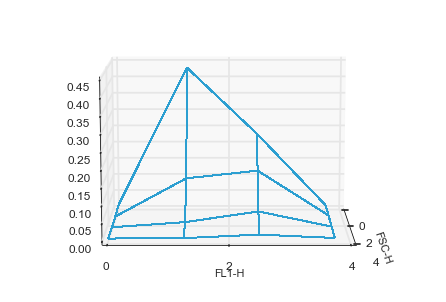

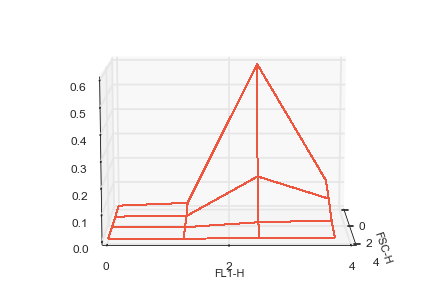

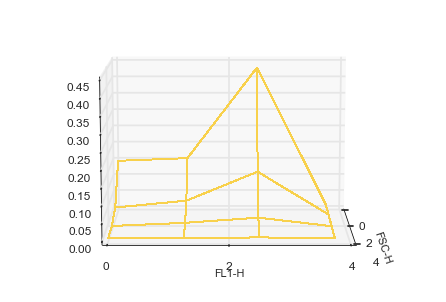

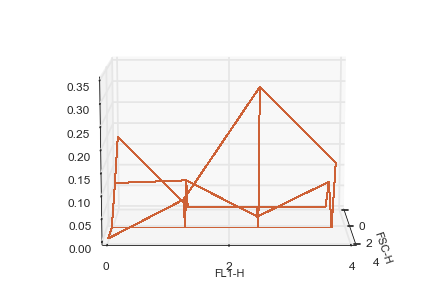

In [186]:


score_list_train = y.eval(feed_dict={u:dist_list,y_:label_list}); 
print score_list_train.shape

best_train_reps = np.argmax(score_list_train,axis=0); 
print best_train_reps

best_train_reps[0] =101;#101; 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter




# Make data.
X_range = np.arange(0, 1,1.0/n_bins)
Y_range = np.arange(0, 1,1.0/n_bins)
X_grid, Y_grid = np.meshgrid(X_range, Y_range)

#print Z.shape
cm_list =['#2c9fd1','#ed5740','#f8d14c','#cd6136','#685858','#185858','#685228','#333858' ]; 
#cm_list = ['#00ccff','#ff5050','#ffff00','b','#993300','#003300']#[cm.Greys,cm.Blues,cm.Oranges,cm.viridis]
for i in range(0,len(best_train_reps)):
    fig = plt.figure()
    ax = Axes3D(fig, elev=10, azim=0,rect=None)
    Z_out = dist_list[best_train_reps[i]]; 

    # Plot the surface.
    surf = ax.plot_wireframe(X_grid, Y_grid, Z_out,rstride=1,cstride=1, color=cm_list[i],
                       linewidth=1, antialiased=False,alpha=1.0)
    #ax.set_zlim(0, 0.1)
    ax.set_xlabel(Channels[1]);
    ax.set_ylabel(Channels[0])
    ax.set_xticks([0,0.4,0.8])
    ax.set_xticklabels([0,2,4])
    ax.grid(True)
    ax.set_yticks([0,0.4,0.8])
    ax.set_yticklabels([0,2,4])
# Customize the z axis.

#ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
#fig.colorbar(surf, aspect=10)
plt.show()

### Static Input-Koopman Regresion ###

In [187]:
Training_Inputs = []; 
print XOR01OD[:]
for ind in range(0,len(XOR01OD)):
    Training_Inputs.append([np.float(XOR01OD[ind])] );

Training_Labels = []; 

test_data = np.ndarray.flatten(XOR01Data[0],order='C')
recon_data = np.reshape(test_data,XOR01Data[0].shape,order='C')
#print recon_data-XOR01Data[0]

for i in range(0,len(XOR01Data)):
    whole_label = XOR01Data[i]; 
    print whole_label.shape
    this_input = XOR01OD[i]
    for k in range(0,30):
        sampl_indices = np.random.randint(0,whole_label.shape[0],(7500))[0]
        print np.max(sampl_indices)
        temp_events = whole_label[sampl_indices]
        this_pdf = gen_pdf(temp_events);
        this_pdf = np.ndarray.flatten(this_pdf,order='C'); 
        Training_Labels.append(this_pdf,);
        Training_Inputs.append(this_input);
print len(Training_Labels)
n_channels = len(Channels);
print n_channels

['0.9', '0.5', '0.9', '1.1', '1.2', '1.2']
(11365, 2)
4870
2627
9048
2407
8543
2116
7830
9963
625
1362
2108
1396
10575
6625
1438
1648
10885
9766
2949
1376
6941
3481
4134
5532
4179
1666
6093
6559
475
10647
(15705, 2)
4195
5271
4625
11060
5497
6101
10003
13475
10123
4700
8897
4930
6620
15464
10198
9712
11211
14741
4411
10676
7108
3681
8609
7001
10048
9638
13423
1769
14210
10328
(8448, 2)
7236
7864
6271
4425
5338
2953
3613
460
4845
7995
694
6475
3778
1712
236
1816
831
6666
8156
7841
5780
2652
1479
4827
2575
4205
5538
5629
5381
5869
(6766, 2)
1821
2085
2579
6714
6457
6077
726
666
674
5545
323
1070
686
5874
1838
1478
5275
5686
3007
3821
4003
6657
5377
378
1049
2456
6145
2469
893
1864
(6028, 2)
4969
2606
2359
2356
3218
3436
3640
1848
4274
678
4499
4371
4955
1382
5084
1328
714
1913
4336
3570
3638
3056
2634
2151
3669
5071
295
251
4121
2048
(12, 2)
5
1
2
3
7
7
1
7
0
3
10
6
2
6
7
9
10
4
4
1
5
11
6
7
0
10
4
1
8
3
180
2


In [188]:
print whole_label.shape


(12, 2)


In [189]:
n_u = 1;
n_y = len(Training_Labels[0])
print n_y
step_size_val = 2.5e-2;
max_width = 1;# 50
n_depth = 4;
hidden_vars_list = np.asarray([max_width]*n_depth);

valid_error_threshold = 1e-3;
test_error_threshold = 1e-3;
max_iters =5000;
#step_size_val = 5e-2;
with_control = 0;
batchsize = 20;
with_input_cond = 0; 
deep_dict_size = 20; 
hidden_vars_list[-1] = deep_dict_size

5


In [190]:
print n_y
print n_u

step_size = tf.placeholder(tf.float32,shape=[]);
sess= tf.InteractiveSession();
W_list,b_list = initialize_Wblist(n_u,hidden_vars_list);
z_list_alias,y,u = mK.initialize_dictionaryNN(n_u,deep_dict_size, hidden_vars_list,W_list,b_list,activation_flag=2);
Kcl = weight_variable((deep_dict_size+n_u,n_y)); 
ypredictor = tf.matmul(y,Kcl); 

y_ = tf.placeholder(tf.float32, [None,n_y]);

print repr(y.get_shape())
print repr(y_.get_shape());

this_loss = tf.reduce_mean(tf.norm(ypredictor-y_,ord=2)/tf.norm(y_)); 
#for ind in range(0,10):
#    optimizer = tf.train.AdagradOptimizer(step_size_val).minimize(this_loss);
#yp_feed  = u;
#yf_feed = y_;
sess.run(tf.initialize_all_variables());
all_histories,good_start = train_net(Training_Inputs,Training_Labels,this_loss,optimizer,batchsize,with_input_cond,u,y,y_,step_size,valid_error_threshold,test_error_threshold,max_iters/10,step_size_val);
#all_histories,good_start = train_net(Training_Inputs,Training_Labels,this_loss,optimizer,batchsize,with_input_cond,u,y,y_,step_size,valid_error_threshold,test_error_threshold,max_iters/10,step_size_val/2);
#all_histories,good_start = train_net(Training_Inputs,Training_Labels,this_loss,optimizer,batchsize,with_input_cond,u,y,y_,step_size,valid_error_threshold,test_error_threshold,max_iters,step_size_val/10);

print this_loss.eval(feed_dict={u:Training_Inputs,y_:Training_Labels})

5
1
[DEBUG] prev_layer_output.get_shape() TensorShape([Dimension(None), Dimension(1)])
[DEBUG] prev_layer_output.get_shape() TensorShape([Dimension(None), Dimension(1)])
[DEBUG] prev_layer_output.get_shape() TensorShape([Dimension(None), Dimension(20)])
Instructions for updating:
Use `tf.global_variables_initializer` instead.
TensorShape([Dimension(None), Dimension(21)])
TensorShape([Dimension(None), Dimension(5)])
Instructions for updating:
Use `tf.global_variables_initializer` instead.


ValueError: Cannot feed value of shape (20,) for Tensor u'Placeholder_31:0', which has shape '(?, 1)'

### 2 Timepoint Analysis

In [ ]:
### 2- point analysis 
### Analysis hyperparameters, metavariables 
import cvxopt;
from cvxpy import Minimize, Problem, Variable,norm1,norm2,installed_solvers,lambda_max;
from cvxpy import norm as cvxpynorm;
import cvxpy;

 
StrainList = list(set(list(DfFinal.StrainID)));
StrainList = StrainList[0:]
StrainList.remove('Beads')
BioRep = list(set(list(DfFinal.BioReplicate)));
TechRep = list(set(list(DfFinal.TechReplicate)));

def gen_Koopman(Yp_list,Yf_list):
    Yp = np.transpose(np.asarray(Yp_list));
    Yf = np.transpose(np.asarray(Yf_list));
    
    K = calc_Koopman(Yf,Yp,flag=1);
    try:
        print "hello world";
    except:
        K = [];
        print "Warning: Koopman calculation failed!"
    return K;

def calc_Koopman(Yf,Yp,flag=1):
    solver_instance = cvxpy.CVXOPT;
    #solver_instance = cvxpy.ECOS;
    if flag==1: # moore penrose inverse, plain ol' least squares Koopman
        #Yp_inv = np.dot(np.transpose(Yp_final), 
        print "Yp.shape: " + repr(Yp.shape)
        print np.linalg.matrix_rank(Yp)
        Yp_inv = np.linalg.pinv(Yp);
        K = np.dot(Yf,Yp_inv);
        

    if flag==2: # cvx optimization approach - L2 + L1 lasso 
        norm1_term = 0.0;
        all_col_handles = [None]*Yf.shape[0]
        for i in range(0,Yf.shape[0]):            
            all_col_handles[i] = Variable(Yf.shape[0],1);
            norm1_term = norm1_term + norm2(all_col_handles[i]);

        operator = all_col_handles[0];
        for i in range(1,Yf.shape[0]):
            operator = cvxpy.hstack(operator,all_col_handles[i]);

        print "[INFO]: CVXPY Koopman operator variable: " +repr(operator);
        print "[INFO]: Yf.shape in calc_Koopman: " + repr(Yf.shape);
        norm2_fit_term = norm2(norm2(Yf-operator*Yp,axis=0));
        objective = Minimize(norm2_fit_term + norm1_term)
        constraints = [];
        prob = Problem(objective,constraints);
        result = prob.solve(verbose=True,solver=solver_instance);
        print "[INFO]: Finished executing cvx solver, printing CVXPY problem status"
        print(prob.status);
        K = operator.value;

    if flag==3:
        operator = Variable(Yf.shape[0],Yf.shape[0])
        objective = Minimize(cvxpynorm(operator,2))
        constraints = [cvxpynorm(Yf-operator*Yp,'fro')/cvxpynorm(Yf,'fro')<0.01 ]
        prob = Problem(objective, constraints)
        result = prob.solve(verbose=True)#(solver=solver_instance);
        print(prob.status);
        K = operator.value;

    return K;

In [ ]:
#print DfPre_Strain.TechReplicate.head()
print DfFin_Strain.TechReplicate.head()

In [ ]:
tot_sub_samples = 500; 
n_bins = 10; 
min_points = 2; 
K_dict = dict();
Channels = ['FL1-H']
#BioRep = [np.float(num) for num in BioRep] 
#TechRep = [np.float(num) for num in TechRep] 
for strain in StrainList:
    DfPre_Strain = DfPre[DfPre['StrainID']==strain];
    DfFin_Strain = DfFinal[DfFinal['StrainID'] == strain];
    for bionum in BioRep:
        
        DfPre_BioNum = DfPre_Strain[DfPre_Strain['BioReplicate']==bionum]
        DfFin_BioNum = DfFin_Strain[DfFin_Strain['BioReplicate']==bionum]
        
        pres = [];
        finals = [];
    
        for technum in TechRep:

            DfPre_BTRep = DfPre_BioNum[DfPre_BioNum['TechReplicate']==technum];
            DfFin_BTRep = DfFin_BioNum[DfFin_BioNum['TechReplicate']==technum]; 

            DfPre_BTRep = prefilter(DfPre_BTRep,Channels);
            DfFin_BTRep = prefilter(DfFin_BTRep,Channels); 
            
            TempOD_Pre = list(set(DfPre_BioNum[DfPre_BioNum['TechReplicate']==technum]['ExtractionOD']));
            TempOD_Fin = list(set(DfFin_BioNum[DfFin_BioNum['TechReplicate']==technum]['ExtractionOD']));
            if len(TempOD_Pre)>1 or len(TempOD_Fin)>1:
                print "Warning, multiple ODs detected.";
                TempOD_Pre = [TempOD_Pre[0]];
            if len(TempOD_Pre)==1:
                try:
                    TempOD_Pre = float(TempOD_Pre[0]);
                    TempOD_Pre = '{0:.1f}'.format(TempOD_Pre);
                except:
                    TempOD_Pre = TempOD_Pre[0][0:3];

                    
            if len(TempOD_Fin)==1:
                try:
                    TempOD_Fin = float(TempOD_Fin[0]);
                    TempOD_Fin = '{0:.1f}'.format(TempOD_Fin);
                except:
                    TempOD_Fin = TempOD_Fin[0][0:3];
                
            if len(TempOD_Fin)==0:
                TempOD_Fin = 'NC';
            if len(TempOD_Fin)==0:
                TempOD_Fin = 'NC';

            try:
                BaseCondition = strain + 'B' + str(int(bionum)) + 'T' + str(int(technum)) ;
                Conditions =[BaseCondition+ 'OD ' + repr(TempOD_Pre) + ' t1',BaseCondition+ 'OD ' + repr(TempOD_Fin) + ' t2']; 
            except:
                BaseCondition = strain + 'B' + repr(bionum) + 'T' + repr(technum);
                Conditions =[BaseCondition+ 'OD ' + repr(TempOD_Pre) + ' t1',BaseCondition+ 'OD ' + repr(TempOD_Fin) + ' t2']; 
            #DfPre_BTRep['FL1-H'] = DfPre_BTRep['FL1-H'].apply(np.log10);
            #DfFinalFin_BTRep['FL1-H'] = DfFinalFin_BTRep['FL1-H'].apply(np.log10); 
            
            if DfPre_BTRep.as_matrix().shape[0]>0 and DfFin_BTRep.as_matrix().shape[0]>0:
                n_samples =np.min([DfPre_BTRep.as_matrix().shape[0],DfFin_BTRep.as_matrix().shape[0]])
                
                DF_List = [DfPre_BTRep.sample(n_samples),DfFin_BTRep.sample(n_samples)]
                DF_List_Overlay = [DfPre_BTRep,DfFin_BTRep];
                for ind in range(0,tot_sub_samples):     
                    pre_pdf = gen_pdf(np.log10(DfPre_BTRep.sample(n_samples).as_matrix()),n_bins);
                    final_pdf = gen_pdf(np.log10(DfFin_BTRep.sample(n_samples)).as_matrix(),n_bins);
                    pres.append(pre_pdf);
                    finals.append(final_pdf);

        
                
                overlay_plot(DF_List_Overlay, Conditions,channel='FL1-H')
        if (len(pres)>=min_points and len(finals)>=min_points):
            Koopman_label = repr(strain)+ 'B' + repr(bionum) + 'T'+ repr(technum);
            K_dict[Koopman_label] = gen_Koopman(pres,finals) 
        else:
            print len(pres)
            print len(finals)
            print Conditions
                        

In [ ]:
for key in K_dict.keys():
    print key + '\t' #+ repr(K_dict[key]) + '\n'
    try:
        ax = gen_heat_map(K_dict[key],[])
        ax.title.set_text(key)
    except:
        continue
    #print K_dict